In [1]:
%load_ext autoreload
%autoreload 2

from os.path import join as oj

import sys
sys.path.append('../src')

from skimage.io import imread, imshow

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# let James know if you run into permissions errors
# TODO: replace matplotlib.animation with napari
plt.rcParams['animation.ffmpeg_path'] = '/clusterfs/fiona/jpduncan/.conda/envs/neurohub/bin/ffmpeg'

from puncta import *

### Import data

In [2]:
%%time

data_dir = '/clusterfs/fiona/yugroup/exllsm'
m3_raw = 'm3_Sample4/raw'

#vol_fname = 'Scan1_NC_Iter_0_ch0_CAM1_stack0000_488nm_0000000msec_0117688843msecAbs_000x_000y_000z_0000t.tif'
vol_fname = 'Scan1_NC_Iter_0_ch1_CAM1_stack0000_560nm_0000000msec_0118824472msecAbs_003x_004y_001z_0000t.tif'
im = imread(oj(data_dir, m3_raw, vol_fname))
im.shape

TiffTag 32781: coercing invalid ASCII to bytes
TiffTag 32781: coercing invalid ASCII to bytes
TiffTag 32781: coercing invalid ASCII to bytes
TiffTag 32781: coercing invalid ASCII to bytes


CPU times: user 30.5 ms, sys: 88.6 ms, total: 119 ms
Wall time: 122 ms


(301, 704, 360)

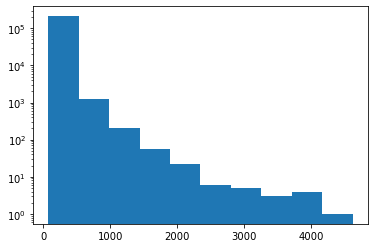

In [3]:
plt.hist(im[:,:,0].flatten())
plt.yscale('log')
plt.show()

In [4]:
fig, ax = plt.subplots()
l = ax.imshow(im[:,:,0], vmin = 0, vmax = np.amax(im))

def animate(i):
    l.set_data(im[:,:,i])

ani = FuncAnimation(fig, animate, frames=im.shape[2])
plt.close()

from IPython.display import HTML
HTML(ani.to_html5_video())

### Parameter defaults (see puncta.py for details)

In [5]:
expansion_factor = 4.09
px_sz = 0.097
px_sz_z = 0.18
sigmas = [2.5, 2.5]
density_vol = 1
find_local_max = True
min_az = 0.1
thresh = None
min_thresh = 0
gauss_kernel_sz = 1
max_quant = .999
min_vox_vol = 516
ball_radius = 2
min_nonzero_frac = 0.1

bw = min_az / 2 / px_sz * expansion_factor # search radius
rad = np.cbrt(density_vol * 3 / 4 / np.pi)
rad_ex = rad * expansion_factor
bw_ex = rad_ex / px_sz # search radius after expansion
struc_el = ball(ball_radius)
px_z_ratio = px_sz_z / px_sz

In [6]:
%%time

if np.sum(im) > 0 and np.count_nonzero(im) >= (im.size * min_nonzero_frac):
    im_gauss = apply_threshold(im, thresh, min_thresh, gauss_kernel_sz, max_quant, verbose=True)
else:
    ValueError(f'There weren\'t enough non-zero voxels in the input volume!')

im_gauss max: 4697.277
Otsu's threshold: 351.000
CPU times: user 3.05 s, sys: 642 ms, total: 3.69 s
Wall time: 3.69 s


In [7]:
%%time

if min_vox_vol > 0:
    # filter out small artifacts from the image
    im_gauss = filter_small_artifacts(im_gauss)
    
if np.sum(im_gauss > 0) == 0:
    ValueError(f'There weren\'t any non-zero voxels after thresholding!')

CPU times: user 9min 11s, sys: 1min 14s, total: 10min 26s
Wall time: 10min 26s


In [8]:
%%time

# calculate local maxima or centroids of synapses
if find_local_max:
    all_max = local_max_3d(
        im_gauss, (7, 7, 7),
        clear_border=False
    )
    max_ind = np.nonzero(all_max)
    puncta_ind = np.array([max_ind[0], max_ind[1], max_ind[2]]).T
else:
    centroids = regionprops_table(labels, properties=['centroid'])
    puncta_ind = np.array([centroids['centroid-0'],
                           centroids['centroid-1'],
                           centroids['centroid-2']]).T

if len(puncta_ind[0]) == 1:
    ValueError(f'There was only one synapse centroid/maximum!')

CPU times: user 2.12 s, sys: 411 ms, total: 2.53 s
Wall time: 2.53 s


In [9]:
%%time

if find_local_max:
    # filter detections closer than 2*bw, replacing with the mean of close points
    puncta_ind = remove_duplicates(puncta_ind, 2*bw)

CPU times: user 4.48 ms, sys: 1.06 ms, total: 5.54 ms
Wall time: 4.9 ms


In [10]:
%%time

# stretch out the z axis
puncta_ind_z = puncta_ind.copy()
puncta_ind_z[:, 2] = puncta_ind_z[:, 2] * px_z_ratio

# get the number of puncta_ind within a radius of bw_ex of each point and
# divide by density_vol to calculate the synapse density
tree = KDTree(puncta_ind_z)
neighbor_count = tree.query_radius(puncta_ind_z, r=bw_ex, count_only=True)
synapse_density = neighbor_count / density_vol

mask = np.zeros(im.shape)
mask[puncta_ind[:, 0], puncta_ind[:, 1], puncta_ind[:, 2]] = synapse_density
mask = dilation(mask, struc_el)

nonzero_idx = im_gauss != 0
clean_vol = np.zeros(im.shape)
clean_vol[nonzero_idx] = im[nonzero_idx]

CPU times: user 2.87 s, sys: 404 ms, total: 3.27 s
Wall time: 3.27 s


In [11]:
fig, ax = plt.subplots()
l = ax.imshow(mask[:,:,0], vmin = 0, vmax = np.amax(mask))

def animate(i):
    l.set_data(mask[:,:,i])

ani = FuncAnimation(fig, animate, frames=mask.shape[2])
plt.close()

from IPython.display import HTML
HTML(ani.to_html5_video())

In [12]:
fig, ax = plt.subplots()
l = ax.imshow(clean_vol[:,:,0], vmin = 0, vmax = np.amax(clean_vol))

def animate(i):
    l.set_data(clean_vol[:,:,i])

ani = FuncAnimation(fig, animate, frames=clean_vol.shape[2])
plt.close()

from IPython.display import HTML
HTML(ani.to_html5_video())